![An image](https://www.fee.unicamp.br/wp-content/uploads/2021/03/feec_2logo_feec_184x73.png)

#Projeto 3 - Análise e Síntese de Sinais de Áudio

EG940 (A) - Prof. Dr. Bruno Sanches Masiero

```
Aluno: Giordano Gatti Gomide - RA:216796
Aluno: Guilherme Rezende de Freitas Leitão - RA:236068
Aluna: Sávia Letícia Menuzzo Quental - RA: 084774
```


#Bibliotecas e import de audio


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import pandas as pd
import scipy.signal as signal
import os

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Obtenção do arquivo wav salvo no google drive
downloaded = drive.CreateFile({'id':'1LMylanzsuuLuOrimdJNEmy53d01FlWkL'}) # replace the id with id of file you want to access
downloaded.GetContentFile('C_Master.wav')

# Áudio de referencia

In [ ]:
Fs = 44100
acordeon, Fs = librosa.load('C_Master.wav', mono=True, sr=Fs)
print(Fs)
Audio(acordeon, rate=Fs)

44100


Text(0, 0.5, 'magnitude')

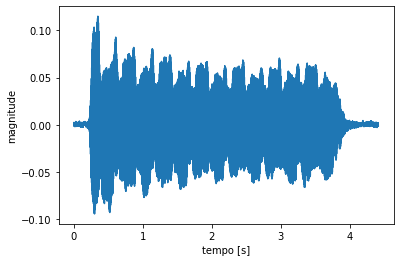

In [ ]:
T = np.linspace(0, len(acordeon)/Fs, len(acordeon))

plt.plot(T, acordeon)
plt.xlabel("tempo [s]")
plt.ylabel("magnitude")

263.2391270073433


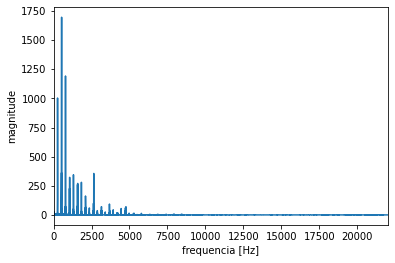

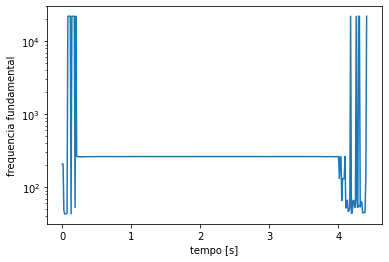

In [ ]:
F = np.linspace(0, Fs, len(acordeon))

acordeon_freq = np.abs(np.fft.fft(acordeon))
plt.plot(F, acordeon_freq)
plt.xlim((0,Fs/2))
plt.xlabel("frequencia [Hz]")
plt.ylabel("magnitude")

hop_len = 512
acordeon_fundamentais = librosa.yin(acordeon, fmin = 20, fmax = Fs/2, hop_length=512, sr=Fs)
T_aux = np.linspace(0, len(acordeon)/Fs, len(acordeon_fundamentais))
plt.figure()
plt.plot(T_aux, acordeon_fundamentais)
plt.yscale('log')
plt.xlabel("tempo [s]")
plt.ylabel("frequencia fundamental")
fundamental = np.median(acordeon_fundamentais)
print(fundamental)

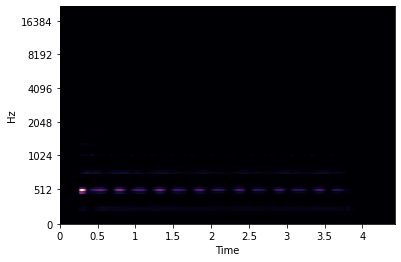

In [ ]:
acordeon_spec = librosa.feature.melspectrogram(acordeon, sr=Fs)
librosa.display.specshow(acordeon_spec, x_axis='time', y_axis='mel', sr=Fs, fmax=Fs/2)

# Síntese aditiva



In [ ]:
#estimando a magnitude e frequencia das harmonicas
harmonics_number = int(Fs/(2*fundamental))
window_size = 400

harmonics_freq = []
harmonics_mag = []
for i in range (1, harmonics_number, 1):
  harmonic = i*fundamental
  sample = int(harmonic/float(Fs/len(acordeon_freq)))
  target = max(acordeon_freq[(sample - (window_size//2)):(sample + (window_size//2))])
  harmonics_mag.append(target)
  harmonics_freq.append(acordeon_freq.tolist().index(target))

print(harmonics_mag)
print(F[harmonics_freq])

[1002.9688527330229, 1696.2169244899408, 1191.9512459151474, 322.43650690635786, 344.3923644146207, 270.0849360902684, 279.79563563776287, 162.2713862147266, 59.6026300827331, 355.8567045486447, 36.77114251165993, 70.85934857463705, 25.228081471164806, 93.06850628954666, 43.73173527394662, 19.239114246727294, 54.80234147818307, 69.97287336393414, 15.02068163956618, 15.121700046900862, 3.6831222148082645, 13.454536313167477, 1.7887698399440923, 5.093818206077518, 2.1860069300708775, 4.491220197169687, 1.0813437303722175, 5.120124516034875, 1.6687054069143887, 5.912294949503166, 0.9983126951403294, 4.728010333603992, 0.5434353186774389, 0.7750328815560874, 0.6008179338291819, 1.2839207944732514, 0.22919483894523537, 0.7276183190336191, 0.21906082447188147, 0.6448973639632093, 0.2374808011835683, 0.6303437038994608, 0.23323081062210774, 0.4723895091851776, 0.19195711043275956, 0.34148365423035026, 0.2521996582773712, 0.5446383801264089, 0.2148549801205878, 0.30139298870985715, 0.198383867

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


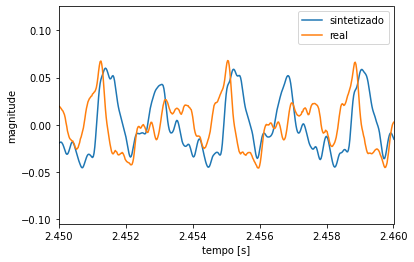

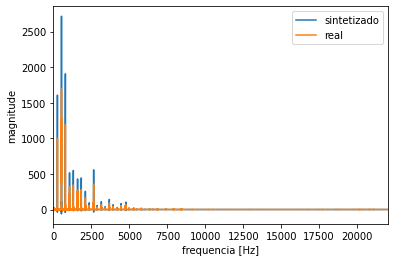

In [ ]:
#Síntese do sinal de interesse
mismatch = 4 #Hz
atenuacao = 8

samples = np.arange(len(T))
acordeon_sint = np.zeros_like(samples).astype(float)
for h in range(len(harmonics_mag)):
    acordeon_sint += harmonics_mag[h]*np.cos(2*np.pi*F[harmonics_freq[h]]*samples*(1/Fs))
    acordeon_sint += (harmonics_mag[h]/atenuacao)*np.cos(2*np.pi*(F[harmonics_freq[h]]-mismatch)*samples*(1/Fs))
acordeon_sint = acordeon_sint/(np.max(acordeon_sint)/np.max(acordeon))

plt.figure()
plt.plot(T, acordeon_sint, label="sintetizado")
plt.plot(T, acordeon, label="real")
plt.legend()
plt.xlabel("tempo [s]")
plt.ylabel("magnitude")
plt.xlim((2.450,2.46))

plt.figure()
plt.plot(F, np.fft.fft(acordeon_sint), label="sintetizado")
plt.plot(F, acordeon_freq, label="real")
plt.xlim((0, Fs/2))
plt.xlabel("frequencia [Hz]")
plt.ylabel("magnitude")
plt.legend()

Audio(acordeon_sint, rate=Fs)


#Síntese da envoltória

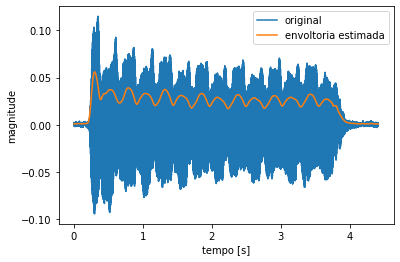

In [ ]:
# Energia ao longo do tempo
hop_len = 512

envolt = librosa.feature.rms(y=acordeon, frame_length=2048, hop_length=hop_len).T
T_env = np.arange(len(envolt))*hop_len/Fs
#envolt = librosa.amplitude_to_db(envolt)

#plt.figure(figsize=(10,2))
plt.plot(T, acordeon, label="original")
plt.plot(T_env, envolt, label="envoltoria estimada")
plt.legend()
plt.xlabel("tempo [s]")
plt.ylabel("magnitude")
plt.show()

In [ ]:
!pip install hmmlearn
from hmmlearn import hmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 217 kB 5.2 MB/s 


In [ ]:
# Inicializando um HMM com emissoes gaussianas
n_regioes = 5
model = hmm.GaussianHMM(n_components=n_regioes, covariance_type="diag", init_params="cm", params="cm")
#parameters trained are c -> covariance and m -> mean

# Probabilidade de inicializar em cada estado
model.startprob_ = np.zeros(n_regioes)
model.startprob_[0] = 1

print(model.startprob_)
# Probabilidade de transicao entre estados
# transmat_[i,j] = Prob de ir do estado i para o j
model.transmat_ = np.zeros( (n_regioes, n_regioes) )
for i in range(n_regioes-1):
  model.transmat_[i,i]=0.6
  model.transmat_[i,i+1]=0.4
model.transmat_[-1,-1]=1
print(model.transmat_)

[1. 0. 0. 0. 0.]
[[0.6 0.4 0.  0.  0. ]
 [0.  0.6 0.4 0.  0. ]
 [0.  0.  0.6 0.4 0. ]
 [0.  0.  0.  0.6 0.4]
 [0.  0.  0.  0.  1. ]]


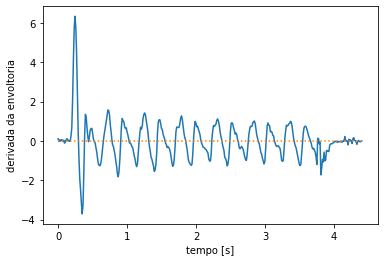

In [ ]:
# derivada do módulo do sinal, normalizada pela média e desvio padrão
derivative = np.diff(envolt, axis=0) #atencao ao eixo da derivada
derivative = (derivative-np.mean(derivative))/np.std(derivative)
plt.figure()
plt.plot(T_env[0:-1], derivative)
plt.plot(T_env, np.zeros_like(T_env), ':')
plt.xlabel("tempo [s]")
plt.ylabel("derivada da envoltoria")#plt.xlim(0,2)

plt.show()

In [ ]:
derivative.shape=(len(derivative),1)
model.fit(derivative[0:2*Fs, :])

GaussianHMM(init_params='cm', n_components=5, params='cm')

In [ ]:
print(model.transmat_)
#print(model.startprob_)
print(model.means_)
print(model.covars_)

[[0.6 0.4 0.  0.  0. ]
 [0.  0.6 0.4 0.  0. ]
 [0.  0.  0.6 0.4 0. ]
 [0.  0.  0.  0.6 0.4]
 [0.  0.  0.  0.  1. ]]
[[ 0.03313951]
 [ 0.00764364]
 [ 0.00991037]
 [ 0.16467936]
 [-0.00131306]]
[[[0.00542118]]

 [[0.00535824]]

 [[0.00460635]]

 [[0.02526886]]

 [[1.04629093]]]


[0, 1, 15, 16, 380]


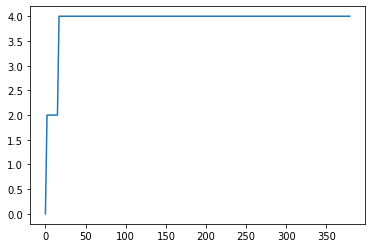

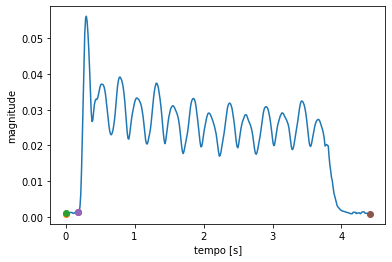

In [ ]:
logprob, Spred = model.decode(derivative)
# O modelo de Markov resulta em um vetor Spred com o mesmo tamanho da nota de
# contendo valores de 0 a 5, sendo 0 a região anterior ao ataque, 1 o ataque,
# 2 o decaimento, 3 a sustentação e 4 o relaxamento/repouso.
plt.plot(Spred)
#plt.xlim([0,100000])
# Locais em que há mudança de estado
mudancas = [n for n in range(len(Spred)-1) if Spred[n]!=Spred[n+1]]
mudancas.append(len(Spred))

print(mudancas)
plt.figure()
plt.plot(T_env, envolt)
for i in mudancas:
  plt.plot(T_env[i], envolt[i], 'o')
#plt.xlim(0,4.1)
#plt.semilogy()
plt.xlabel("tempo [s]")
plt.ylabel("magnitude")
plt.show()

[array([8.020162], dtype=float32), array([0.80284244], dtype=float32), array([-1.3602053], dtype=float32), array([-0.05201719], dtype=float32)] [0, 1, 15, 16, 380]


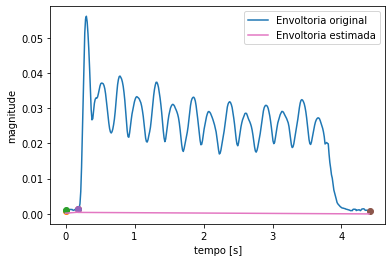

In [ ]:
#print(onset, pico, decaimento, sustain)
def curva(fs, pontos_relevantes, derivadas):
  curva = np.zeros(pontos_relevantes[-1]) # Base
  for i in range(len(pontos_relevantes)-1):
    curva[pontos_relevantes[i]:pontos_relevantes[i+1]] = derivadas[i]
  curva = np.cumsum(curva)/fs
  return curva

def derivadas(Fs, envolt, mudancas): # Encontrar derivadas "ligando" os pontos
  deriv = []
  for i in range(len(mudancas)-1):
    d = (envolt[mudancas[i+1]]-envolt[mudancas[i]]) / (mudancas[i+1]-mudancas[i])
#    np.polyfit(range(mudancas[i],mudancas[i+1]), envolt[mudancas[i]:mudancas[i+1]], deg=1)
    deriv.append(d*Fs)
  return deriv

deriv = derivadas(Fs, envolt, mudancas)
print(deriv, mudancas)
env = curva(Fs, mudancas, deriv)

plt.figure()
plt.plot(T_env, envolt, label='Envoltoria original')
for i in mudancas:
  plt.plot(T_env[i], envolt[i], 'o')
plt.plot(T_env[0:len(env)], env, label='Envoltoria estimada')
plt.legend()
plt.xlabel("tempo [s]")
plt.ylabel("magnitude")
plt.show()

#Som Final

In [ ]:
env_sint = []
last = 0
for i in env:
  if (i==0):
    env_sint += np.zeros(hop_len).tolist()
  else:
    env_sint += np.linspace((last), i, hop_len).tolist()
  last = i
print(len(env_sint))

194560


In [ ]:
acordeon_sint_final = env_sint*acordeon_sint
acordeon_sint_final = acordeon_sint_final/(np.max(acordeon_sint_final)/np.max(acordeon_sint))

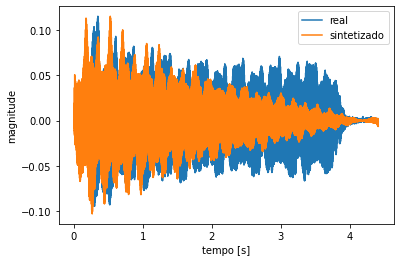

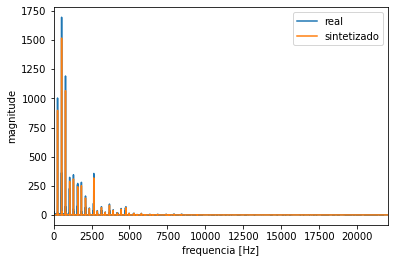

In [ ]:
plt.figure()
plt.plot(T, acordeon, label="real")
plt.plot(T, acordeon_sint_final, label="sintetizado")
plt.xlabel("tempo [s]")
plt.ylabel("magnitude")
plt.legend()

plt.figure()
plt.plot(F, acordeon_freq, label="real")
plt.plot(F, np.abs(np.fft.fft(acordeon_sint_final)), label="sintetizado")
plt.xlim((0, Fs/2))
plt.xlabel("frequencia [Hz]")
plt.ylabel("magnitude")
plt.legend()

Audio(acordeon_sint_final, rate=Fs)

#Síntese FM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(15, 381)
(10, 1) (10, 2)
 The best solution found:
 [3.90950593e-02 1.00462407e+00 9.84209500e-01 1.14244066e-01
 2.60235394e-01 3.98855094e+00 9.50499362e-01 9.49288280e-04
 1.59282275e+01 0.00000000e+00]

 Objective function:
 -234780.3238754041


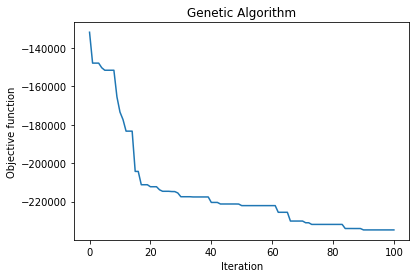

In [ ]:
!pip install geneticalgorithm
target = acordeon
def descritores(x, texture_size=15):
  # Calcular descritores e janela de textura
  filt = np.hanning(texture_size)

  y0 = librosa.feature.mfcc(x, n_mfcc=13)
  y1 = librosa.feature.spectral_centroid(x)
  y2 =librosa.feature.spectral_flatness(x, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='constant', amin=1e-10, power=2.0)

  #y0_ = scipy.signal.oaconvolve(filt, y0)
  #y1_ = scipy.signal.oaconvolve(filt, y1)

  #print(y0.shape, y1.shape)

#  y0_ = scipy.signal.oaconvolve(filt, y0)
#  y1_ = scipy.signal.oaconvolve(filt, y0)

  y0_ = y0
  y1_ = y1
  y2_ = y2
  return np.vstack( (y0_, y1_, y2_) )

X_target = descritores(target[0:Fs*5])
print(X_target.shape)
X_target /= np.sum(X_target**2)

# Modelo 2:
# $x(t) = a(t) \cos (fc t + m(t) fc \cos(\beta fc t) )$
# Onde:
# a(t) é uma envoltória no tempo (adsr, indo de 0 a 1)
# fc é a frequência da portadora
# m(t) é uma envoltória no tempo que multiplica a modulação (adsr, indo de 0 a N)
# beta é dado por 2^k, k inteiro, que determina a frequência da moduladora

# Envoltorias
def envoltoria(x, a, d, s, r, fs, low_end=0, high_end=1):
  a_ = int(a*fs)
  d_ = int(d*fs)
  r_ = int(r*fs)
  s_ = int(len(x) - a_ - d_ - r_)
  if (s_ < 0):
    print("Erro! Envoltoria maior que o sinal!")
    return None

  env_a = np.linspace(low_end, high_end, a_)
  env_d = np.linspace(high_end, s, d_)
  env_s = np.ones(s_) * s
  env_r = np.linspace(s, low_end, r_)

  env = np.hstack( (env_a, env_d, env_s, env_r) )

  return env

def glissando(freq, fs):
  arg = (2 * np.pi / fs) * np.cumsum(freq)
  x = np.cos(arg)
  return x


def fm(T, fs, fc, a, d, s, r, afm, dfm, sfm, rfm, N, k):
  t = np.arange(fs*T)/fs

  freq = np.cos(2*np.pi*2**k * fc * t)
  env_m = envoltoria(freq, afm, dfm, sfm, rfm, fs, 0, N)
  freq *= fc * env_m
  freq += fc


  x = glissando(freq, fs)
  env_t = envoltoria(freq, a, d, s, r, fs, 0, 1)
  x *= env_t

  return x


def fitness(p):
  x_ = fm(5, Fs, fundamental, p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9])
  X_ = descritores(x_)
  dif = np.sum( (X_ - np.resize(X_target,(np.shape(X_))))) #############ESSA LINHA PODE TA ESTRANHA
  fit = -dif
  return fit

vartype=np.array([['real'],['real'],['real'],['real'],['real'],['real'],['real'],['real'],['real'],['int']])
varbound=np.array([[0,0.3],[0,2],[0.1,1],[0,2.5],[0,0.3],[1,4],[0.1,1],[0,0.1],[0,16],[0,0]])
print(vartype.shape, varbound.shape)

from geneticalgorithm import geneticalgorithm as ga

algorithm_param = {'max_num_iteration': 100,\
                   'population_size':10,\
                   'mutation_probability':0.3,\
                   'elit_ratio': 0.2,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}


model=ga(function=fitness,dimension=10,variable_type_mixed=vartype,variable_boundaries=varbound, algorithm_parameters=algorithm_param)

model.run()

convergence=model.report
solution=model.output_dict

p = solution['variable']
x_est = fm(5, Fs, fundamental, p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], 0)
Audio(data=x_est, rate=Fs)

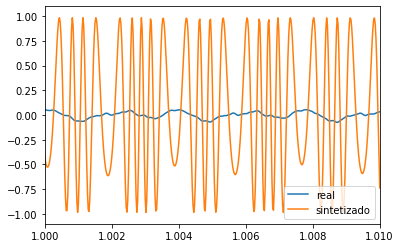

(0.0, 22050.0)

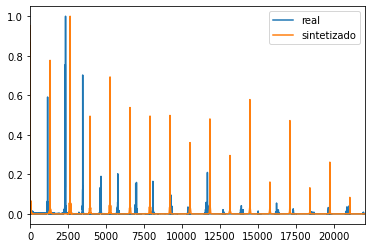

In [ ]:
plt.figure()
n = np.linspace(0, len(target)/Fs, len(target))
plt.plot(n, target)
n2 = np.linspace(0, len(x_est)/Fs, len(x_est))
plt.plot(n2, x_est)
plt.legend(['real', 'sintetizado'])
plt.xlim(1,1.01)
plt.show()

FFtarget = abs(np.fft.fft(target))/max(abs(np.fft.fft(target)))
FFx_est = abs(np.fft.fft(x_est))/max(abs(np.fft.fft(x_est)))

plt.plot(FFtarget)
plt.plot(FFx_est)
plt.legend(['real', 'sintetizado'])
plt.xlim(0,Fs/2)